# A convolutional neural network based plant disease detection system

## Installing required packages

The notebook was completed on Google Colab due to its GPU capability. To successfully run the code below, one must first install the required packages: fastai (0.7.0), pytorch, torchvision, PIL (4.1.1) and image.

In [0]:
!pip install fastai==0.7.0
!pip install https://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip install torchvision
!pip install Pillow==4.1.1
!pip install image

## Importing required libraries

In [5]:
# Import the torch and torchvision library
import torch
import torchvision
print(torch.__version__)
print(torch.cuda.is_available())

0.4.1
True


In [0]:
#import all modules and functions in the fastai library
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

#For automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Load the data

The data was downloaded from links given on this [Github Repo](https://github.com/MarkoArsenovic/DeepLearning_PlantDiseases). This dataset is consisted of 38 disease classes from [PlantVillage](https://plantvillage.psu.edu/) dataset and 1 background class from Stanford's open dataset of background images - [DAGS](http://dags.stanford.edu/projects/scenedataset.html). 

In [0]:
!gdown https://drive.google.com/uc?id=0B_voCy5O5sXMTFByemhpZllYREU
#unzip the data file
!tar -xvf PlantVillage.tar.gz
#rename the folder val as valid
!mv ./PlantVillage/val ./PlantVillage/valid

In [0]:
#set data source path
PATH = './PlantVillage/'

## Initial data exploration

The original data was split in train and validation folder, and inside each subdirectory, the folder name represents the class name of all the images in that subfolder. With this data structure and using the fastai library, all the training and validation image data can be conveniently imported simultaneously using one function call `ImageClassifierData.from_paths`. This function also take cares of getting the label information from the folder name and the image preprocessing tasks(resizing, cropping, scaling/normalizing) automatically. 

In [0]:
arch=resnet34
sz=224 #set input image size
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

Indeed, there are 39 class labels in this dataset.

In [10]:
print(data.c)
print(data.classes)

39
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target

First, let's take a look at a random sample of 6 images from the training dataset

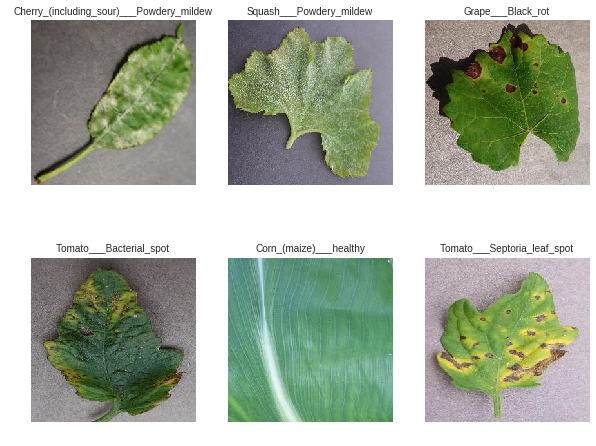

In [11]:
# Choose 6 random images from the training set and getting their true labels
idxs = np.random.choice(np.arange(data.trn_ds.n), 6, replace=False)
imgs = [Image.open(PATH+data.trn_ds.fnames[i]) for i in idxs]
labels = [data.trn_ds.fnames[i].split('/')[1] for i in idxs]

# Plot the images
f = plt.figure(figsize=(10,8))
for i in range(len(imgs)):
  subplts = f.add_subplot(2, 3, i+1)
  subplts.axis('Off')
  subplts.set_title(labels[i], fontsize=10)
  plt.imshow(imgs[i])

## Training the classification model

Next, we will start training our model. We will start by doing transfer learning with a pretrained convolutional neural network model ResNet34 and only train the last fully connected layer as a classifier. To create the transfer learning model we will need to use function `ConvLearner.pretrained` from the Learner class in the fastai library and feed a pre-trained model to it.

### Choosing a learning rate

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 28769557.56it/s]


  0%|          | 0/688 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 172/172 [01:05<00:00,  3.60it/s]


One of the most important hyperparameters in training a deep learning model is the learning rate. The method learn.lr_find() can help find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186), where it searches a range of learning rates from a small value to a high value until the loss stops decreasing.

In [13]:
lrf=learn.lr_find()

 83%|████████▎ | 570/688 [00:14<00:03, 38.11it/s, loss=2.95]

We can plot the loss versus the learning rate to see where our loss stops decreasing.  The loss is improving until learning rate lr = 0.1. We choose a learning rate close to the minimum loss point by setting learning rate lr = 0.008.

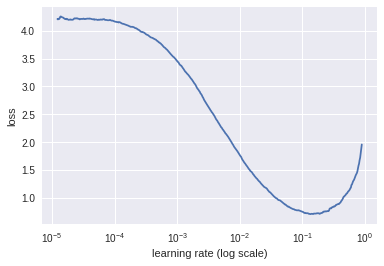

In [14]:
learn.sched.plot()

### Initial training with resnet layers freezed

Start training the model for 10 epochs with learning rate lr = 0.008 and precompute = True (freeze all but the last layers of the resnet34 model)

In [15]:
%%time

learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.008, 10)

/usr/local/lib/python3.6/dist-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   accuracy   
    0      0.354377   0.19516    0.943929  
    1      0.278738   0.146491   0.954653  
    2      0.228227   0.123825   0.961287  
    3      0.200752   0.1105     0.96474   
    4      0.18632    0.105533   0.965194  
    5      0.172246   0.099097   0.96683   
    6      0.193481   0.097902   0.966921  
    7      0.163022   0.093593   0.968375  
    8      0.160673   0.090915   0.970829  
    9      0.141903   0.084571   0.972192  
CPU times: user 2min 26s, sys: 1min 49s, total: 4min 16s
Wall time: 3min 9s


### Improving the model performance by training with unfreezed resnet layer parameters

After training for the first 10 epochs, we already achieved 97.2% accuracy on the validation dataset, which is very impressive. But we can do better by fine-tuning the lower layer parameters and train a full model. Here, we will also use two special techniques called *cosine annealing* (cyclically changing the learning rates) and *differential learning rates* (keep small tweaks, i.e. gradually decreasing, the learning rate for the lower layers)

In [16]:
%%time
# unfreeze the lower layers
learn.precompute=False
learn.unfreeze()

# cosine annealing and differential learning rates for lower layers
lr=np.array([1e-4,1e-3,1e-2])*0.8
learn.fit(lr, 3, cycle_len=2, cycle_mult=2, best_save_name='resnet34_best')

epoch      trn_loss   val_loss   accuracy   
    0      0.08705    0.043122   0.985278  
    1      0.051255   0.038075   0.98655   
    2      0.037212   0.028449   0.990367  
    3      0.020376   0.02422    0.992366  
    4      0.013091   0.022674   0.993003  
    5      0.013128   0.021404   0.993003  
    6      0.015099   0.022689   0.992185  
    7      0.012875   0.022599   0.99273   
    8      0.009532   0.01971    0.993457  
    9      0.004961   0.019046   0.993548  
    10     0.007669   0.018572   0.994366  
    11     0.005891   0.017673   0.994457  
    12     0.003235   0.018154   0.994184  
    13     0.004778   0.017516   0.994547  
CPU times: user 2h 38min 10s, sys: 29min 14s, total: 3h 7min 24s
Wall time: 2h 31min 11s


### Saving and loading the model for future use

After training for another 14 epochs we achieved 99.5%  accuracy on the validation dataset, which is almost a perfect model. It's time to save the model for reproducing the results in the future or put this model into production.

In [0]:
learn.save('resnet34_retrain')
# to save the pytorch model
torch.save(learn.model,'resnet34_retrain.pth')


In [0]:
learn.load('resnet34_retrain')

##Analyzing results

Generate the final prediction labels and probabilities



In [19]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds)        # get probabilities
probs.shape

(11004, 39)

### Confusion matrix

Let's plot out the confusion matrix to see correctly classified and mis-classified samples. Again the confusion matrix shows almost a perfect model (very few off-diagonal values)

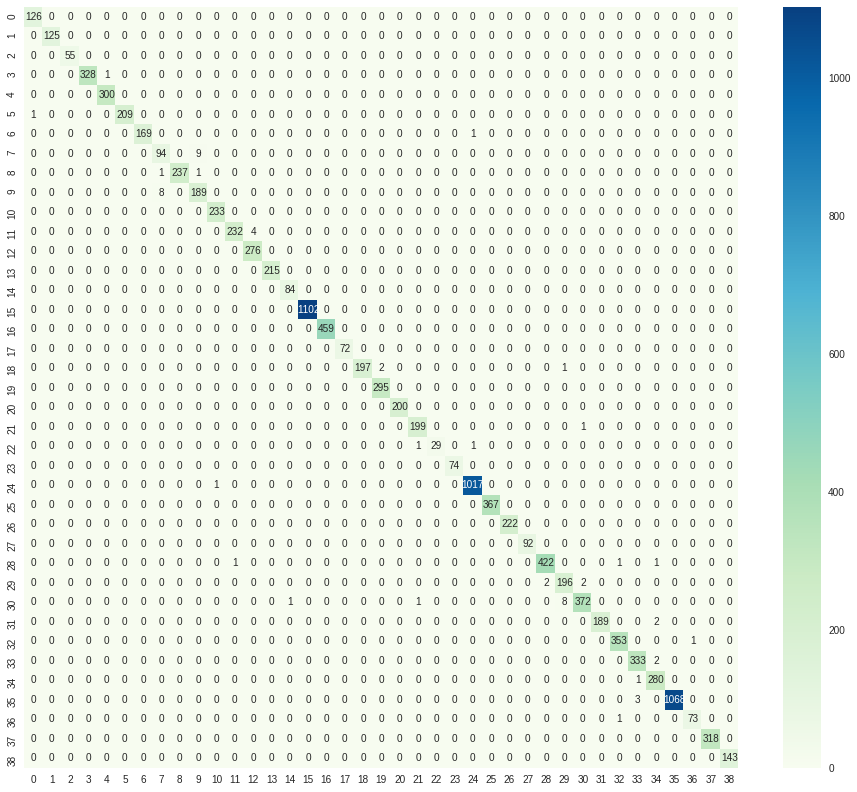

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data.val_y, preds)
plt.figure(figsize=(16,14))
sns.heatmap(cm,annot=True,cmap = 'GnBu',fmt ='g')

### Inspect correct and mis-classified images

Define helper functions to inspect the correctly classified and mis-classified samples

In [0]:
def get_label(idx): return data.val_ds.fnames[idx].split('/')[1]  # get true label for an image from its index 

def get_topk_probs(idx, k=5): 
  
  topk_idx = np.argsort(probs[idx,:])[-k:][::-1]
  labels = [data.classes[i] for i in topk_idx]
  return labels, probs[idx,topk_idx]

def choose_random_sample(n=5, random_state=17): 
  """Randomly choose n correctly and correctly labeled images  
  
  """
  img_idx = np.arange(data.val_ds.n)
  correct_pred_idx = img_idx[preds == data.val_y]
  wrong_pred_idx = img_idx[preds != data.val_y]

  np.random.seed(seed=random_state)
  correct_samples_idx = np.random.choice(correct_pred_idx, n, replace=False)
  wrong_samples_idx = np.random.choice(wrong_pred_idx, n, replace=False)
  
  return correct_samples_idx, wrong_samples_idx


In [0]:
def img_plots(idxs, figsize=(20,8)):
  
    f = plt.figure(figsize=figsize)
    #load images
    imgs = [Image.open(PATH+data.val_ds.fnames[i]) for i in idxs]
    labels = [get_label(i) for i in idxs]
    
    for i in range(len(idxs)):
        subplts = f.add_subplot(2, len(idxs), i+1)
        subplts.axis('Off')
        subplts.set_title(labels[i], fontsize=10)
        plt.imshow(imgs[i])
        
        pred_labels, top_probs = get_topk_probs(idxs[i])
        subplts = f.add_subplot(2, len(idxs), i+1+len(idxs))
        plt.bar(pred_labels, top_probs)
        plt.xticks(rotation=-85)
                                   

Plot 5 randomly chosen correctly classified samples

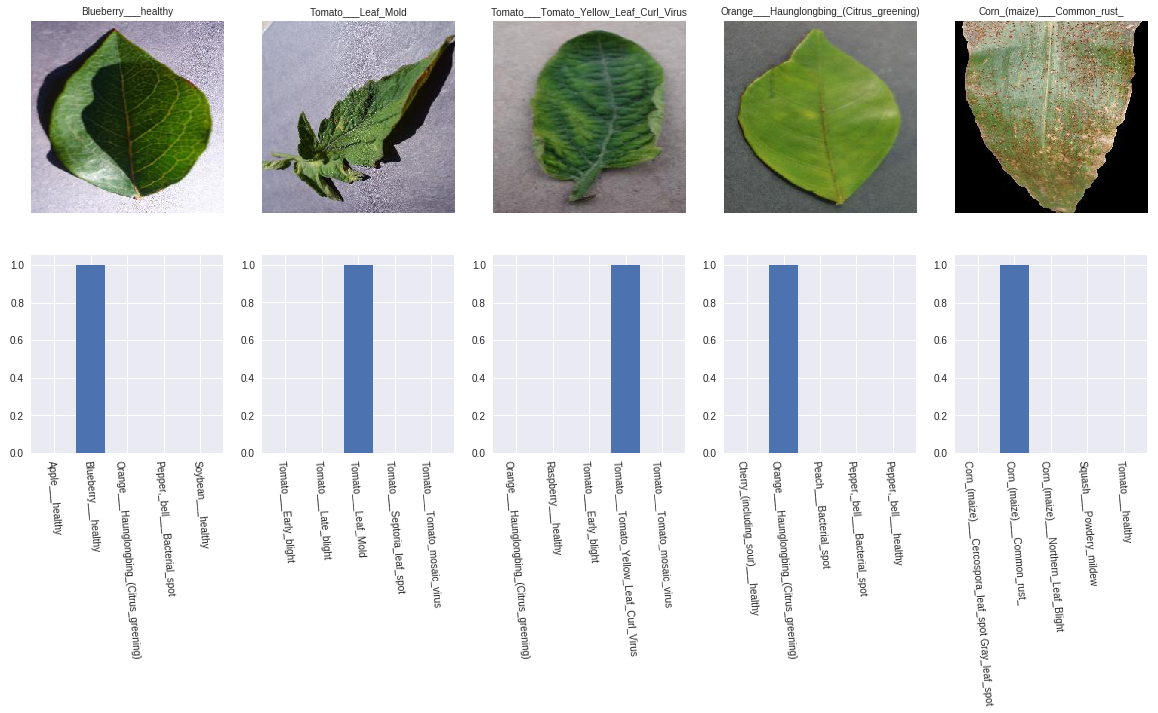

In [33]:
correct_samples_idx, wrong_samples_idx = choose_random_sample(n=5)
img_plots(correct_samples_idx)   

Plot 5 randomly chosen mis-classified samples. We can see here the model is a bit uncertain about its predicted label and true label (the true label appears as the No.2 highest ranking predicted class).

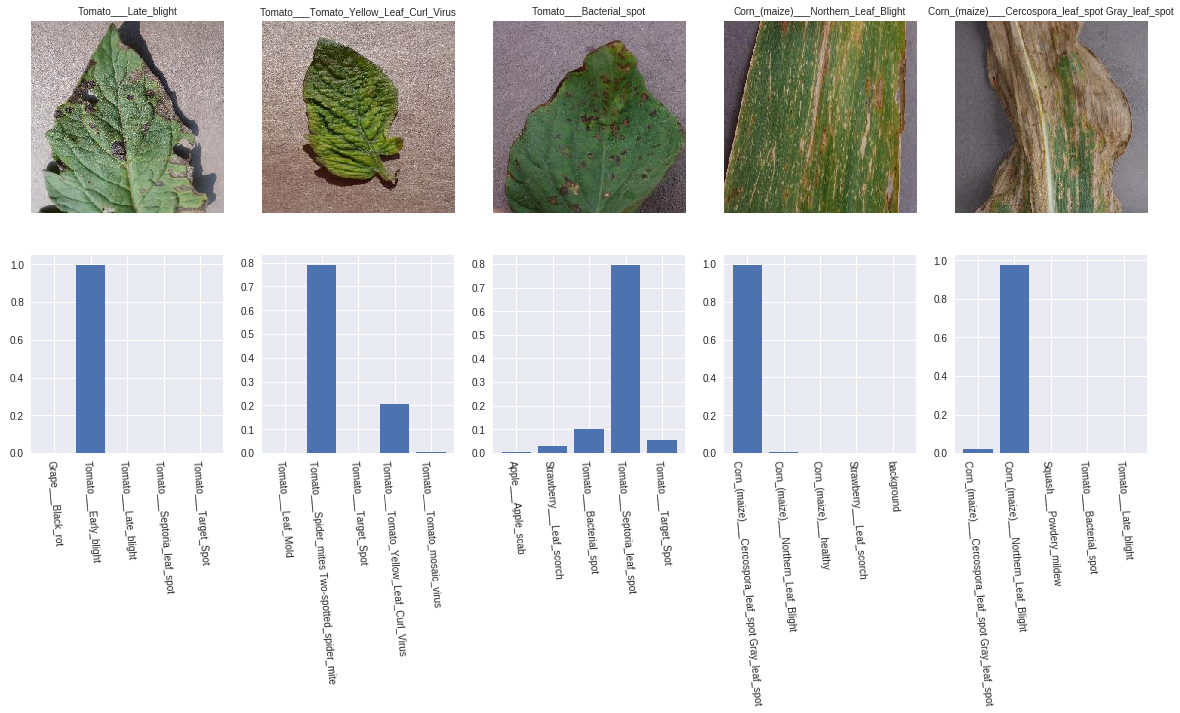

In [34]:
img_plots(wrong_samples_idx)   

## Conclusions

I have built a convolutional neural network based classifier that achieved 99.5% prediction accuracy on the [PlantVillage](https://plantvillage.psu.edu/) dataset using transfer learning and the PyTorch and Fastai library.

## Future work

I plan to put this model into production and build a on-line web API or app so that anyone with images of diseased plants can use this tool to get a quick and accurate diagnosis.

## References

This project was inspired by these publications and libraries:

* https://arxiv.org/abs/1511.08060
* https://github.com/MarkoArsenovic/DeepLearning_PlantDiseases
* https://pytorch.org/
* https://github.com/fastai